This notebook has an attempt at running Simulated annealing in an constrained enviroment. We assume we know the confusion matrix(Assume it to be near identity matrix) and the class distribution. We treat this problem like a Traveling Salesman Problem where we swap the order of classes in order to match the data and achieve the maximum likelihood. This was an initial starting attempt at solving the class inference problem using the Simulated annealing approach.

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
%matplotlib inline

In [106]:
#Reading in the data
data = np.load('../data/preset_MC_500_5_4.npz.npy')
trueCls = np.load('../data/preset_MC_500_5_4_reference_classes.npy')
data.shape

(500, 5, 4)

In [107]:
#Inferring the number of classes and data length
numData = data.shape[0]
numExperts = data.shape[1]
numClasses = data.shape[2]

In [108]:
confMat = np.eye(numClasses) + 0.001
confMat = confMat/np.sum(confMat, axis=1)[:, np.newaxis]
#Since each of the k classes have a 1/k ratio in total data
data_list = []
for idx in range(numClasses):
    class_dat = [idx for i in range(numData/numClasses)]
    data_list = data_list + class_dat
data_num = np.array(data_list)
np.random.shuffle(data_num)
z = np.eye(numClasses)[data_num]

In [109]:
def mc_likelihood(value=data, z=z, confMat=confMat):
    """
    value - data
    z - observed classes
    confMat - confidence matrix
    """
    log_like = 0
    numData = data.shape[0]
    numExperts = data.shape[1]
    numClasses = data.shape[2]
    for data_idx in range(numData):
        dat = data[data_idx]
        observed_cls = z[data_idx]
        class_num = np.where(observed_cls == 1)[0][0]
        log_like += np.sum(np.multiply(observed_cls,np.sum(np.multiply(np.sum(dat, axis=0),\
                            np.log(confMat[class_num])))))
    return log_like

In [110]:
def swap_rows(z, row_idx1, row_idx2):
    new_z = np.copy(z)
    temp = z[row_idx1,:]
    new_z[row_idx1,:] = z[row_idx2,:]
    new_z[row_idx2,:] = temp
    return new_z

In [111]:
mc_likelihood(value=data, z=z, confMat=confMat)

-12443.239905108436

In [112]:
def simulated_annealing_mc(z, confMat, data, starting_temp=100, reanneal=0.1, num_iterations=100):
    temp = starting_temp
    likelihood_trace = []
    best_likelihood_trace = []
    temp_trace = []
    best_start = z
    best_lik = -np.inf
    for i in range(num_iterations):
        swap_idx = np.random.choice(range(z.shape[0]), size=2, replace=False)
        z_new = swap_rows(z, swap_idx[0], swap_idx[1])
        new_lik = mc_likelihood(data, z_new, confMat)
        old_lik = mc_likelihood(data, z, confMat)
        u = np.random.uniform()
        prob = min([1, np.exp(-(new_lik - old_lik)/temp)])
        #print prob, u
        #Always accepting if the likelihood increases
        if new_lik > old_lik:
            z = z_new
            if new_lik > best_lik:
                best_lik = new_lik
                best_start = z_new
            likelihood_trace.append(new_lik)
        #Accepting based on the probability if the error does not reduce
        elif prob <= u:
            z = z_new
            if new_lik > best_lik:
                best_lik = new_lik
                best_start = z
            likelihood_trace.append(new_lik)
        else:
            likelihood_trace.append(old_lik)
        #Reducing temperature every 10th iteration
        if i%10 == 0:
            temp = temp*0.99
        #Reannealing if the temperature is too low
        if temp < reanneal:
            temp = 1
        temp_trace.append(temp)
        best_likelihood_trace.append(best_lik)
    return likelihood_trace, best_likelihood_trace, temp_trace, best_start, best_lik

In [113]:
likelihood_trace, best_likelihood_trace, temp_trace, best_start, best_lik =\
simulated_annealing_mc(z, confMat, data, num_iterations=20000)

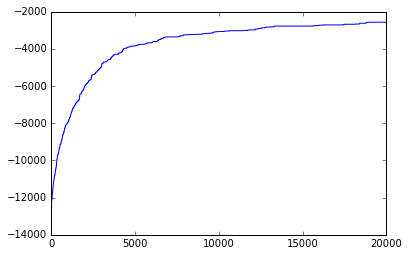

In [114]:
plt.plot(likelihood_trace)

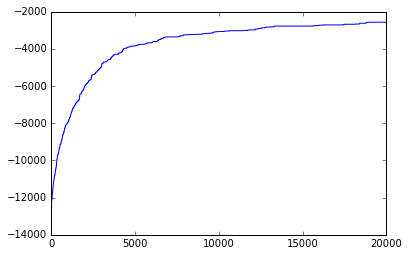

In [115]:
plt.plot(best_likelihood_trace)

In [116]:
np.sum(np.argmax(best_start, axis=1) == trueCls)

476

In [97]:
trueCls

array([3, 0, 2, 1, 3, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 1, 0, 3, 1, 0, 0, 0,
       2, 2, 2, 0, 3, 0, 2, 3, 3, 0, 1, 0, 3, 3, 1, 3, 1, 0, 1, 3, 1, 1, 0,
       2, 0, 1, 3, 3, 3, 2, 1, 1, 1, 3, 3, 3, 2, 1, 0, 0, 1, 0, 2, 2, 3, 1,
       0, 0, 2, 3, 1, 1, 2, 0, 3, 0, 2, 0, 1, 0, 2, 2, 2, 1, 0, 2, 1, 2, 3,
       2, 0, 0, 1, 2, 3, 3, 2])

In [98]:
np.argmax(best_start, axis=1)

array([3, 0, 2, 1, 3, 1, 1, 2, 1, 1, 3, 0, 1, 0, 3, 2, 3, 0, 3, 1, 0, 3, 0,
       2, 2, 2, 0, 1, 0, 2, 3, 3, 0, 1, 0, 1, 3, 3, 0, 1, 0, 2, 3, 1, 1, 0,
       2, 3, 2, 3, 3, 3, 0, 1, 1, 1, 1, 3, 2, 2, 1, 0, 0, 0, 0, 2, 3, 1, 1,
       2, 3, 2, 3, 1, 3, 0, 0, 3, 0, 2, 2, 1, 0, 2, 2, 2, 1, 0, 2, 1, 2, 3,
       2, 0, 0, 1, 2, 3, 3, 2])

#### YN case

In [117]:
#Reading in the data
data = np.load('../data/preset_YN_200_5_4.npz.npy')
trueCls = np.load('../data/preset_MC_200_5_4_reference_classes.npy')
data.shape

(200, 5, 4, 2)

In [118]:
#Inferring the number of classes and data length
numData = data.shape[0]
numExperts = data.shape[1]
numClasses = data.shape[2]

In [120]:
confMatHat = np.eye(numClasses) + 0.001
confMatHat = confMatHat/np.sum(confMatHat, axis=1)[:, np.newaxis]
#Since each of the k classes have a 1/k ratio in total data
data_list = []
for idx in range(numClasses):
    class_dat = [idx for i in range(numData/numClasses)]
    data_list = data_list + class_dat
data_num = np.array(data_list)
np.random.shuffle(data_num)
z = np.eye(numClasses)[data_num]

In [121]:
def mc_likelihood2(value=data, z=z, confMatHat=confMatHat):
    """
    value - data
    z - observed classes
    confMat - confidence matrix
    """
    log_like = 0
    numData = data.shape[0]
    numExperts = data.shape[1]
    numClasses = data.shape[2]
    for data_idx in range(numData):
        dat = data[data_idx]
        observed_cls = z[data_idx]
        class_num = np.where(observed_cls == 1)[0][0]
        data_val = np.sum(dat, axis=0)
        computed_val = np.sum(np.multiply(data_val[:,1], np.log(confMatHat[class_num]))) + \
                        np.sum(np.multiply(data_val[:,0], np.log(1-confMatHat[class_num])))
        log_like += np.sum(np.multiply(observed_cls, computed_val))
    
    return log_like

In [123]:
def simulated_annealing_yn(z, confMat, data, starting_temp=100, reanneal=0.1, num_iterations=100):
    temp = starting_temp
    likelihood_trace = []
    best_likelihood_trace = []
    temp_trace = []
    best_start = z
    best_lik = -np.inf
    for i in range(num_iterations):
        swap_idx = np.random.choice(range(z.shape[0]), size=2, replace=False)
        z_new = swap_rows(z, swap_idx[0], swap_idx[1])
        new_lik = mc_likelihood2(data, z_new, confMat)
        old_lik = mc_likelihood2(data, z, confMat)
        u = np.random.uniform()
        prob = min([1, np.exp(-(new_lik - old_lik)/temp)])
        #print prob, u
        #Always accepting if the likelihood increases
        if new_lik > old_lik:
            z = z_new
            if new_lik > best_lik:
                best_lik = new_lik
                best_start = z_new
            likelihood_trace.append(new_lik)
        #Accepting based on the probability if the error does not reduce
        elif prob <= u:
            z = z_new
            if new_lik > best_lik:
                best_lik = new_lik
                best_start = z
            likelihood_trace.append(new_lik)
        else:
            likelihood_trace.append(old_lik)
        #Reducing temperature every 10th iteration
        if i%10 == 0:
            temp = temp*0.99
        #Reannealing if the temperature is too low
        if temp < reanneal:
            temp = 1
        temp_trace.append(temp)
        best_likelihood_trace.append(best_lik)
    return likelihood_trace, best_likelihood_trace, temp_trace, best_start, best_lik

In [124]:
likelihood_trace, best_likelihood_trace, temp_trace, best_start, best_lik =\
simulated_annealing_yn(z, confMat, data, num_iterations=20000)

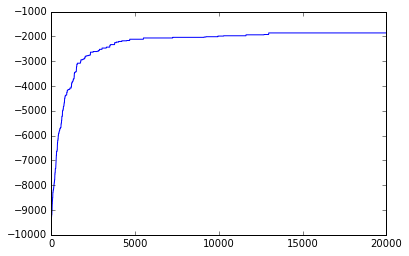

In [125]:
plt.plot(likelihood_trace)

In [126]:
np.sum(np.argmax(best_start, axis=1) == trueCls)

198